# Phased Array

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy import signal

In [2]:
C = sc.c
PI = sc.pi

For phased array to work well, we need to first define the far and near fields. In the far field regions, we can assume that the wave has become planar. This threshold is defined commonly using the Fraunhofer Distance:
$$
d_F = \frac{2D^2}{\lambda}
$$
where $D$ is the largest antenna dimension and $\lambda$ is the wavelength. We also have to note this approximation only works if $d_F >> D$ and $d_F >> \lambda$

In [3]:
def calculate_far_field_distance(D_x, D_y, frequency):
    """
    Calculate the far field distance for an antenna array.
    
    Parameters:
    D_x (float): Antenna size in x direction (meters)
    D_y (float): Antenna size in y direction (meters)
    frequency (float): Frequency in Hz
    
    Returns:
    float: Far field distance in meters
    """
    wavelength = C / frequency  # Wavelength in meters
    D = max(D_x, D_y)  # The largest antenna dimension
    R_ff = 2 * D**2 / wavelength  # Far field distance
    return R_ff



In [4]:
D_x = 1 # Antenna size in x direction
D_y = 1.5 # Antenna size in y direction
frequency = 50e9 # Frequency in Hz
wavelength = C / frequency # Wavelength in meters

# The largest antenna dimension
D = max(D_x, D_y)

# Calculate the far field distance
R_ff = calculate_far_field_distance(D_x, D_y, frequency)
print(f"For an array with dimensions {D_x}m x {D_y}m at {frequency/1e9}GHz, the far field distance is {R_ff:.2f}m.")

For an array with dimensions 1m x 1.5m at 50.0GHz, the far field distance is 750.52m.


## 1-Dimensional Phase Array

We will start off with a 1-Dimensional phase array. We let L be the extra distance a wave has to travel to get to the next array element from the element that received the first strike of the incoming wave. We also know the antenna spacing defined as $d_x$. As such, for an incoming wave with an angle of $\theta$ with respect to the perpendicular direction of the array span we have:
$$
L = d_x \cdot \sin{\theta}
$$

To calculate the phase shift we can multiply this by $\frac{2\pi}{\lambda}$,
$$
\Delta \phi = d_x \cdot \sin{\theta} \cdot \frac{2\pi}{\lambda}
$$

The above equation allows us to calculate the phase shift required, $\Delta \phi$ for a steering angle $\theta$.

In [5]:
def cal_phase_shift(antenna_spacing, steering_angle_deg, frequency):
    """
    Calculate the phase shift for a given antenna spacing, steering angle, and frequency.
    
    Parameters:
    antenna_spacing (float): Spacing between antennas in meters
    steering_angle_deg (float): Steering angle in degrees
    frequency (float): Frequency in Hz
    
    Returns:
    float: Phase shift in radians
    """
    wavelength = C / frequency  # Wavelength in meters
    phase_shift_value = antenna_spacing * np.sin(np.radians(steering_angle_deg)) * (2 * PI / wavelength)
    return phase_shift_value

In [6]:
f_0 = 50e9  # Centre Frequency for computing phas shifts in Hz
wavelength_0 = C / f_0  # Wavelength in meters
k_0 = 2 * PI / wavelength_0  # Wavenumber in radians per meter

# We use 1/2 wavelength because of the Nyquist criterion. f_s >= C / (2 * wavelength)
d_x = 0.5 * wavelength  # Antenna spacing in meters

# Number of array elements
N = 8 

# Steering angle in degrees
steering_angle_deg = 0 

# Calculate the initial phase shift for the steering angle
u_0 = np.sin(np.radians(steering_angle_deg))

# Angle theta for plotting
theta = np.linspace(-PI, PI, 1000) # Angle in radians for plotting
u = np.sin(theta)

# Calculate the phase shift for the given parameters
phase_shift_value = cal_phase_shift(d_x, steering_angle_deg, frequency)
print(f"Phase shift for antenna spacing {d_x:.4f}m and steering angle {steering_angle_deg} degrees at {frequency/1e9}GHz is {phase_shift_value:.4f} radians.")

Phase shift for antenna spacing 0.0030m and steering angle 0 degrees at 50.0GHz is 0.0000 radians.


In [7]:
# Phase shift required to attain 
scan_dir = 20 # degrees
scan_dir_rad = np.radians(scan_dir) # radians

phase_shift = cal_phase_shift(d_x, scan_dir, f_0)  # Phase shift for the scan direction
phase_shift_deg = np.degrees(phase_shift)  # Convert phase shift to degrees

print(f"To scan to {scan_dir} degrees off boresight, with an operating frequency of {f_0/1e9:.2f} GHz, a phase shift of {phase_shift_deg:.2f} degrees is needed")

To scan to 20 degrees off boresight, with an operating frequency of 50.00 GHz, a phase shift of 61.56 degrees is needed


## Antenna Pattern

For an antenna pattern, there are two components comprising of the element pattern and the array factor. The element pattern is the pattern radiated from each antenna element while the array factor accounts for the combined pattern changes when multiple antenna elements are arranged together in an array (this includes effects of their relative phase and amplitude weights).

The two contributers mentioned determines the shape and directionality of the antenna pattern.

Below we look into the array factor first which can be modelledusing fourier transform.

Recall that in fourier transform of a discretised time domain, we have a sinc function in the frequency domain. Similarly, we can treat each of our array element as a sample in the spatial domain, and if we can somehow sweep using the scan angles we can get the shape of the signal. The equation derived would yield us:
$$
F[\theta] = \sum_{m=0}^{M-1} w[m] e^{-j(k \cdot d_x \cdot \sin{(\theta)} \cdot m)}
$$
where:
- $k$ is the wave number defined as $\frac{2\pi}{\lambda}$
- $m$ is the index of the array element
- $w$ are the weights of the array element
- $d_x$ is the array element distance separation
- $\theta$ is the unit angle for the sweep angle
- $F$ is the array factor as a function of scan angle

$F[\theta]$ just gives us the contribution of the array from a single array. With it, we can sweep $\theta$, to know how our array will perform at any angle in the range of $-\pi$ to $\pi$.

To calculate the relative phase shift we will take the difference between the sample phase shift and the reference phase shift:
$$
\phi = k \cdot d_x \cdot \sin{\theta} \\
\phi_0 = k \cdot d_x \cdot \sin{\theta_0} \\
\Delta \phi = \phi - \phi_0 = k \cdot d_x \cdot (\sin{\theta} - \sin{\theta_0}) 
$$

This $\Delta \phi$ phase shift can be found in the array factor equation.

In [8]:
# Below we compute the array factor (AF) for the antenna array
def compute_af(weights):
    """
    Compute the array factor for a linear antenna array with given weights.
    Parameters:
    weights (np.ndarray): Weights for each antenna element
    Returns:
    np.ndarray: Array factor as a function of angle
    """
    n = np.arange(weights.size)
    AF = np.sum(
        weights[:, None] * np.exp(1j * n[:, None] * d_x * k_0 * (u - u_0)), axis=0
    )
    AF /= AF.max() # Normalize the array factor
    return AF

The properties of the signal can be seen, the half-power beam width is estimated to be:
$$
hpbw = 70 \cdot \frac{\lambda}{D}
$$
where:
- $\lambda$ is the wavelength of the signal
- $D$ is the lobe diameter or sensor diameter

The first null bandwidth can be estimated as:
$$
fnbw = 2 \cdot hpbw
$$

In [9]:
hpbw = 70 * wavelength_0 / (N * d_x)  # Half Power Beamwidth in sine space
fnbw = 2 * hpbw  # First Null Beamwidth in sine space

print(f"First null beamwidth in sine space: {fnbw}")
print(f"First null beamwidth in radians: {np.radians(fnbw):.2f}")

First null beamwidth in sine space: 35.0
First null beamwidth in radians: 0.61


The below function gives you the element pattern — i.e., how a single antenna element (e.g. a rectangular aperture) radiates power in space. Since a rectangular aperture behaves like a slit in the x and y directions. If you take the Fourier Transform of a rectangular function, you get a sinc function in the angular domain. Hence, we simulate a sinc element pattern.

For the x-direction, we will take the direction cosine along the x-axis $\sin{\theta} \cos{\phi}$. We also take $\frac{L}{2}$ because our phase shift distribution is defined over $-\frac{L}{2}$ and $\frac{L}{2}$ where $L$ is the full aperature length.

Similarly for the y-direction, we calculate the direction cosine, $\sin{\theta} \sin{\phi}$.

$\frac{L}{2}$ was obtained from the 1D Fourier Transform of the rectangular function:
$$
\int_{-\frac{L}{2}}^{\frac{L}{2}}e^{-jkx\sin{\theta}}dx = \frac{\sin{(\frac{kL}{2} \sin{\theta})}}{\frac{kL}{2}\sin{\theta}} \cdot L
$$
This is simplified to:
$$
L \cdot \text{sinc}{(\frac{kL}{2} \sin{\theta})}
$$

By taking the 2D Fourier Transform of the rectangular aperature that extends in both x and y, our resulting radiation pattern is:
$$
E(\theta, \phi) = E_x(\theta, \phi) \cdot E_y(\theta, \phi)
$$
The above gives us the overall angular pattern.

In [10]:
def sinc_element_pattern(theta, phi, L, W, wavelength_0):
    k = 2 * np.pi / wavelength_0
    E_theta = np.sinc(k * L / 2 * np.sin(theta) * np.cos(phi))
    E_phi = np.sinc(k * W / 2 * np.sin(theta) * np.sin(phi))
    return np.abs(E_theta * E_phi)

Below, we define a microstrip antenna property to get the element pattern.

In [11]:
epsilon_r = 2.2  # relative permittivity of substrate
h = 1.6e-3  # substrate height (m)

epsilon_eff = (epsilon_r + 1) / 2 + (epsilon_r - 1) / 2 * (
    1 + 12 * h / wavelength_0
) ** -0.5
L = wavelength_0 / (2 * np.sqrt(epsilon_eff))  # patch length (m)
W = wavelength_0 / 2 * np.sqrt(2 / (epsilon_r + 1))  # patch width (m)

EP = sinc_element_pattern(theta, 0, L, W, wavelength_0)

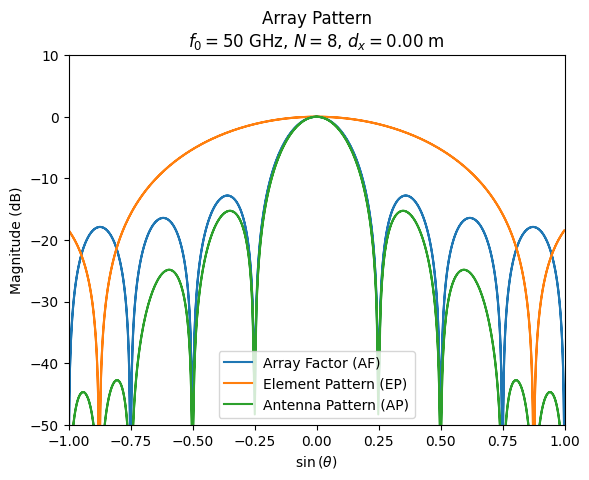

In [12]:
elems = np.ones(N)
n = np.arange(N) # Index of the antenna elements

# AF is normalised by dividing by the number of elements. 
AF = np.sum(np.exp(1j * n[:, None] * d_x * k_0 * (u - u_0)), axis=0) / N

AP = AF * EP

fig, ax = plt.subplots()
ax.plot(u, 20 * np.log10(np.abs(AF)), label="Array Factor (AF)")
ax.plot(u, 20 * np.log10(np.abs(EP)), label="Element Pattern (EP)")
ax.plot(u, 20 * np.log10(np.abs(AP)), label="Antenna Pattern (AP)")
ax.set_xlim(-1, 1)
ax.set_ylim(-50, 10)
# ax.axhline(-13, c="b", linestyle="--", label="Side-lobe level")
ax.set_xlabel(r"$\sin{(\theta)}$")
ax.set_ylabel(r"Magnitude (dB)")
ax.set_title(
    f"Array Pattern\n$f_0 = {f_0 / 1e9:.0f}$ GHz, $N = {N}$, $d_x = {d_x:.2f}$ m"
)
ax.legend()
plt.show()

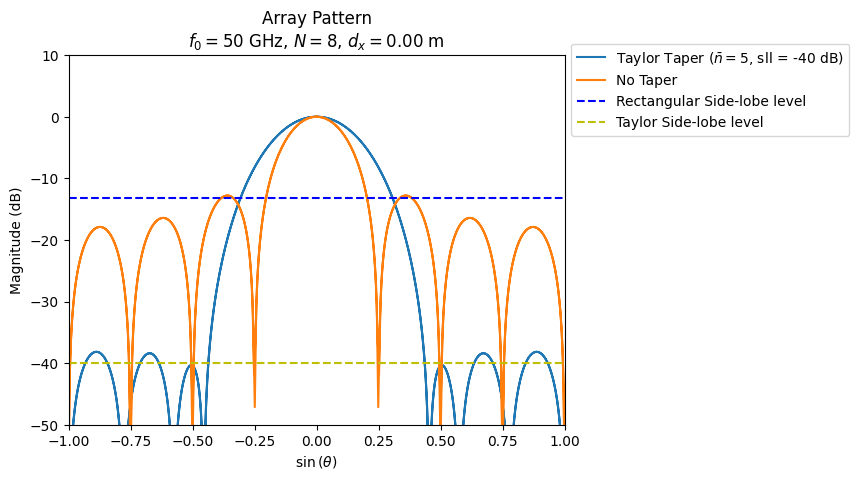

In [13]:
weights_rect = np.ones(N)
# Taylor taper parameters
nbar = 5    # Number of nearly constant level sidelobes adjacent to the mainlobe.
sll = 40    # Side-lobe level in dB relative to the mainlobe peak.
weights_taylor = signal.windows.taylor(N, nbar=nbar, sll=sll)
AF_rect = compute_af(weights_rect)
AF_taylor = compute_af(weights_taylor)


fig, ax = plt.subplots()
ax.plot(
    u,
    20 * np.log10(np.abs(AF_taylor)),
    label=f"Taylor Taper ($\\bar{{n}} = {nbar}$, sll = {-sll} dB)",
)
ax.plot(
    u,
    20 * np.log10(np.abs(AF_rect)),
    label=f"No Taper",
)
ax.set_xlim(-1, 1)
ax.set_ylim(-50, 10)
ax.axhline(-13.2, c="b", linestyle="--", label="Rectangular Side-lobe level")
ax.axhline(-40, c="y", linestyle="--", label="Taylor Side-lobe level")
ax.set_xlabel(r"$\sin{(\theta)}$")
ax.set_ylabel(r"Magnitude (dB)")
ax.set_title(
    f"Array Pattern\n$f_0 = {f_0 / 1e9:.0f}$ GHz, $N = {N}$, $d_x = {d_x:.2f}$ m"
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1.05))
plt.show()

## 2-Dimensional Phase Array
In 2-Dimensions, the 1-Dimensional phase array can be further extended to include the 2nd dimension. Hence, we split the weight $w[m]$ into two components, namely $b_m[m]$ and $c_n[n]$. We also introduce a new phase dimension $\phi$ in the n-direction, while maintaining $\theta$ in the m-direction.

Hence, the Array Factor (AF) can be separated into these two components:
$$
F[\theta] = \sum_{m=0}^{M-1} b_m \cdot e^{-jk\cdot d_x \cdot \sin{(\theta)}\cdot m} \\
F[\phi] = \sum_{n=0}^{N-1} c_n \cdot e^{-jk\cdot d_y \cdot \sin{(\phi)}\cdot n} \\
$$

Combining these two components into a single Array Factor, results in the following:
$$
F[\theta, \phi] = F[\theta] \cdot F[\phi] = \sum_{m=0}^{M-1} b_m \cdot e^{-jk\cdot d_x \cdot \sin{(\theta)}\cdot m} \sum_{n=0}^{N-1} c_n \cdot e^{-jk\cdot d_y \cdot \sin{(\phi)}\cdot n}
$$

We can also rewrite the above with a single coefficient $a_{m,n}$ to represent $b_m[m]$ and $c_n[n]$. 
$$
F[\theta, \phi] = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} |a_{m,n}| \cdot e^{j(k_0[m \cdot dx \cdot \sin{(\theta)} + n \cdot dy \cdot \sin{(\phi)}])}
$$

In [66]:
N = 10  # number of elements in horizontal dimension
M = 10  # number of elements in vertical dimension

n = np.arange(N)  # array for summing over n
m = np.arange(M)  # array for summing over m

d_x = wavelength_0 / 2  # x spacing
d_y = wavelength_0 / 2  # y spacing

steering_angle_theta_deg = 30  # theta steering angle
steering_angle_phi_deg = 30  # phi steering angle

u_0 = np.sin(np.radians(steering_angle_theta_deg))  # theta steering angle in sine space
v_0 = np.sin(np.radians(steering_angle_phi_deg))  # phi steering angle in sine space

In [67]:
npts = 100  # number of points for plotting

# Below we use sine space for theta and phi (spherical coordinates)
# theta = np.linspace(-PI, PI, npts)
# phi = np.linspace(-PI, PI, npts)
# u2 = np.sin(theta) * np.cos(phi) # sine space for theta
# v2 = np.sin(theta) * np.sin(phi) # sine space for phi

# Below we use a mesh grid for u and v in sine space
u2 = np.linspace(-1, 1, npts)
v2 = np.linspace(-1, 1, npts)

U, V = np.meshgrid(u2, v2)  # mesh grid of sine space

In [68]:
def compute_af_2d(weights_n, weights_m, d_x, d_y, k_0, u_0, v_0):
    AF_m = np.sum(
        weights_m[:, None, None]
        * np.exp(-1j * m[:, None, None] * d_x * k_0 * (U - u_0)),
        axis=0,
    )
    AF_n = np.sum(
        weights_n[:, None, None]
        * np.exp(-1j * n[:, None, None] * d_y * k_0 * (V - v_0)),
        axis=0,
    )
    print(f"AF_m shape: {AF_m.shape}, AF_n shape: {AF_n.shape}, U shape: {U.shape}, V shape: {V.shape}")
    # Normalize the array factor
    AF = AF_m * AF_n / (M * N)
    return AF

AF_m shape: (100, 100), AF_n shape: (100, 100), U shape: (100, 100), V shape: (100, 100)


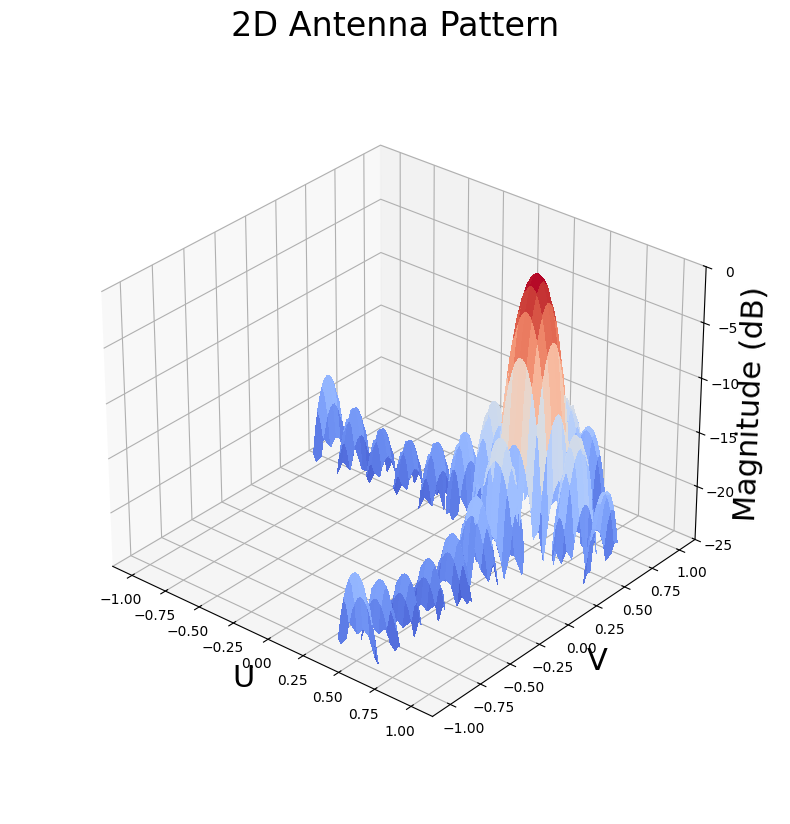

In [69]:
%matplotlib inline
from matplotlib import cm

z_min = -25
z_max = 0

weights_n = np.ones(N)
weights_m = np.ones(M)
AF_rect = compute_af_2d(weights_n, weights_m, d_x, d_y, k_0, u_0, v_0)
AF_rect_log = 20 * np.log10(np.abs(AF_rect))
AF_rect_log_mask = np.where(AF_rect_log > z_min, AF_rect_log, np.nan)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(U, V, AF_rect_log_mask, cmap=cm.coolwarm, antialiased=False)
ax.set_zlim(z_min, z_max)
ax.set_title("2D Antenna Pattern", fontsize=24)
ax.set_xlabel("U", fontsize=22)
ax.set_ylabel("V", fontsize=22)
ax.set_zlabel("Magnitude (dB)", fontsize=22)
ax.view_init(elev=30, azim=-50, roll=0)
ax.set_box_aspect(None, zoom=0.85)
plt.show()

Window n shape: (10,), Window m shape: (10,)


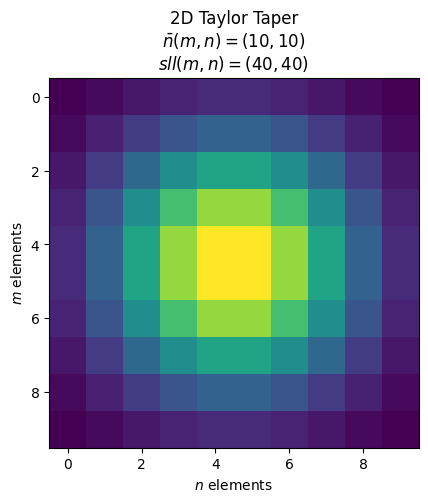

In [70]:
nbar_n = 10 # Number of nearly constant level sidelobes in the n direction
nbar_m = 10 # Number of nearly constant level sidelobes in the m direction
sll_n = 40  # Side-lobe level in dB relative to the mainlobe peak in the n direction
sll_m = 40  # Side-lobe level in dB relative to the mainlobe peak in the m direction
window_n = signal.windows.taylor(N, nbar=nbar_n, sll=sll_n)
window_m = signal.windows.taylor(M, nbar=nbar_m, sll=sll_m)
print(f"Window n shape: {window_n.shape}, Window m shape: {window_m.shape}")

fig, ax = plt.subplots()
ax.set_title(
    f"2D Taylor Taper\n"
    f"$\\bar{{n}}(m,n) = ({nbar_m}, {nbar_n})$\n"
    f"$sll (m,n) = ({sll_m}, {sll_n})$"
)
ax.set_xlabel("$n$ elements")
ax.set_ylabel("$m$ elements")
ax.imshow(np.outer(window_n, window_m))
plt.show()

In [71]:
AF_taylor = compute_af_2d(window_n, window_m, d_x, d_y, k_0, u_0, v_0)

AF_m shape: (100, 100), AF_n shape: (100, 100), U shape: (100, 100), V shape: (100, 100)


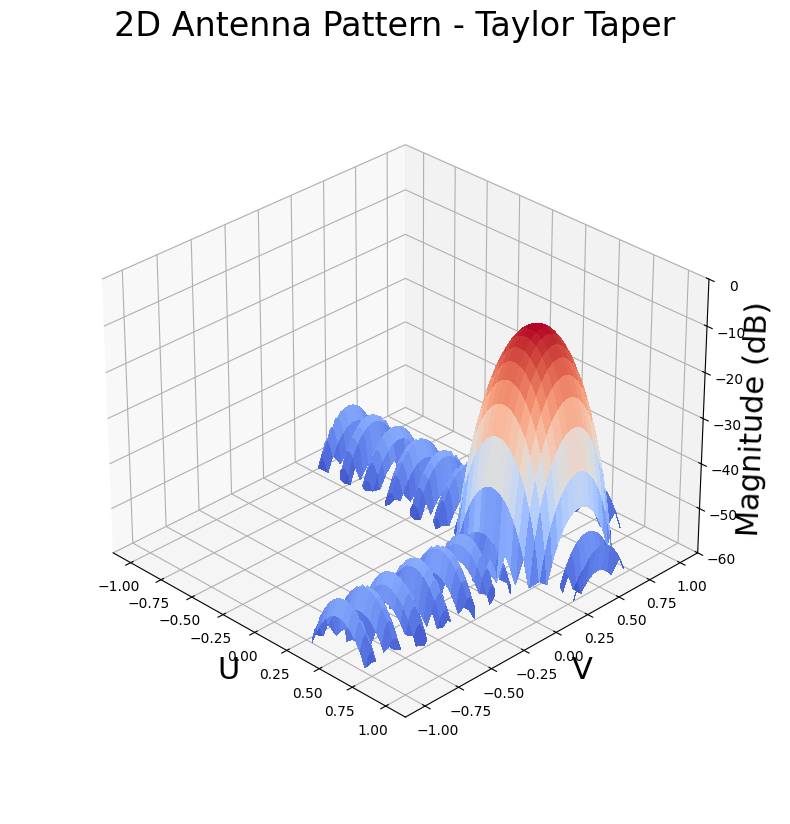

In [72]:
%matplotlib inline

z_min = -60
z_max = 0


AF_taylor_log = 20 * np.log10(np.abs(AF_taylor))
AF_taylor_log_mask = np.where(AF_taylor_log > z_min, AF_taylor_log, np.nan)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(U, V, AF_taylor_log_mask, cmap=cm.coolwarm, antialiased=False)
ax.set_zlim(z_min, z_max)
ax.set_title("2D Antenna Pattern - Taylor Taper", fontsize=24)
ax.set_xlabel("U", fontsize=22)
ax.set_ylabel("V", fontsize=22)
ax.set_zlabel("Magnitude (dB)", fontsize=22)
ax.view_init(elev=30, azim=-45, roll=0)
ax.set_box_aspect(None, zoom=0.85)
plt.show()

AF_m shape: (100, 100), AF_n shape: (100, 100), U shape: (100, 100), V shape: (100, 100)


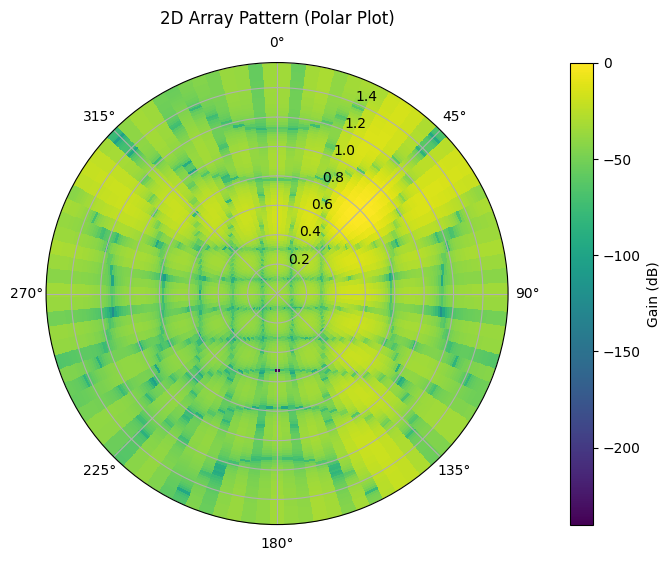

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume AF (npts x npts) and (U, V) are already computed from meshgrid
npts = U.shape[0]
AF_dB = 20 * np.log10(np.abs(AF) / np.max(np.abs(AF)) + 1e-12)  # dB scale

# Convert (U, V) → (theta, phi)
R = np.sqrt(U**2 + V**2)
R_clipped = np.clip(R, 0, 1)  # only physical directions
theta = np.arcsin(R_clipped)  # in radians
phi = np.arctan2(V, U)  # [-pi, pi]

# Build 1D angular and radial coordinates
theta_vals = np.linspace(0, np.pi/2, npts)     # 0 to 90 degrees
phi_vals = np.linspace(-np.pi, np.pi, npts)    # -180 to 180 degrees

# Meshgrid for plotting
Phi, Theta = np.meshgrid(phi_vals, theta_vals)

# Convert (theta, phi) to direction cosines
U = np.sin(Theta) * np.cos(Phi)
V = np.sin(Theta) * np.sin(Phi)

# Compute array factor on polar grid
AF = compute_af_2d(weights_n, weights_m, d_x, d_y, k_0, u_0, v_0)  # recompute if needed
AF_dB = 20 * np.log10(np.abs(AF) / np.max(np.abs(AF)) + 1e-12)

# Plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
pcm = ax.pcolormesh(Phi, Theta, AF_dB, shading='auto', cmap='viridis')
ax.set_title("2D Array Pattern (Polar Plot)", va='bottom')
ax.set_rlim(0, np.pi/2)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
cbar = plt.colorbar(pcm, pad=0.1)
cbar.set_label("Gain (dB)")
plt.show()
